<a href="https://colab.research.google.com/github/Nornalite/cnn_voice_recognition/blob/main/Syksy2024_projektitehtava.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade pip
!pip install --upgrade keras
!pip install -U -q tensorflow
#!pip show keras


  Using cached pip-24.2-py3-none-any.whl.metadata (3.6 kB)
Using cached pip-24.2-py3-none-any.whl (1.8 MB)
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 19.7 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1


In [ ]:
# Nämä importattiin simple audio mallissa.
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from keras import layers
from keras import models
from IPython import display



In [ ]:
import sys

import numpy as np
from keras import Model
from keras import Layer

def import_model(filepath: str) -> Model:
    """Load model from file"""
    model: Model = models.load_model(filepath)
    return model

model = import_model('model_export.keras')
print(model.summary())



Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resizing_24 (Resizing)               │ (None, 32, 32, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ normalization_24 (Normalization)     │ (None, 32, 32, 1)           │               3 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_48 (Conv2D)                   │ (None, 30, 30, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_49 (Conv2D)                   │ (None, 28, 28, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_25 (MaxPooling2D)      │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_51 (Dropout)                 │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_24 (Flatten)                 │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_51 (Dense)                     │ (None, 128)                 │       1,605,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_52 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_52 (Dense)                     │ (None, 8)                   │           1,032 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,876,829 (18.60 MB)

 Trainable params: 1,625,608 (6.20 MB)

 Non-trainable params: 3 (16.00 B)

 Optimizer params: 3,251,218 (12.40 MB)

None


In [ ]:
def get_layer_weights(layer: str, model: Model) -> list[np.ndarray]:
    """Get layer weights from given model"""
    return model.get_layer(layer).get_weights()


def get_weights_shape(layer: list[np.ndarray]):
    tmp = []
    for i in layer:
        tmp.append(i.shape)
    return tmp



class DummyLayer(Layer):
    def __init__(self):
        super(DummyLayer, self).__init__()

    def call(self, inputs):
        return inputs

def get_reference_layer(layer: str, model: Model):
    """Split the model in to three parts start, layer and rest.

    Example:
    ```python
    model = import_model("../model/test_model.keras")
    (start, layer, end) = get_reference_layer("dense", model)

    result = start(waveform)
    layer_result = layer(result)
    print(layer_result)
    ```
    """
    modelStart = models.Sequential()
    selectedLayer: Layer
    modelEnd = models.Sequential()

    start = True
    l: Layer
    for l in model.layers:
        if l.name == layer:
            start = False
            selectedLayer = l
            continue
        if start:
            modelStart.add(l)
        else:
            modelEnd.add(l)

    if not len(modelStart.layers):
        modelStart.add(DummyLayer())
    if not len(modelEnd.layers):
        modelEnd.add(DummyLayer())

    modelStart.build(model.input_shape)
    modelEnd.build(selectedLayer.output.shape)
    return (modelStart, selectedLayer, modelEnd)



In [ ]:
DATASET_PATH = 'data/mini_speech_commands_extracted/mini_speech_commands'

data_dir = pathlib.Path(DATASET_PATH)
if not data_dir.exists():
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='data')

182082353/182082353 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [ ]:
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram



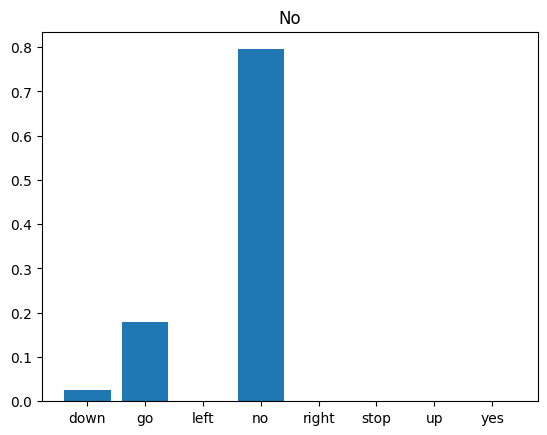

In [29]:
x = data_dir/'no/01bb6a2a_nohash_0.wav'
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
x = tf.squeeze(x, axis=-1)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis,...]

prediction = model(x)
x_labels = ['down', 'go', 'left', 'no', 'right', 'stop', 'up', 'yes']
plt.bar(x_labels, tf.nn.softmax(prediction[0]))
plt.title('No')
plt.show()

display.display(display.Audio(waveform, rate=16000))

In [85]:
# Muunnetaan kaikki sisään otettu tavallisiksi Python-listoiksi koska tässä taloudessa ei käytetä mitään
# NumPyjä >:c

def resize(data, width, height):
  print(len(data), len(data[0]))

  result = [[[0 for _ in range(len(data[0][0]))] for _ in range(height)] for _ in range(width)]
  #print(len(result), len(result[0]), len(result[0][0]))

  #Listojen suhteet
  ratio_x = len(data) / width
  ratio_y = len(data[0]) / height
  print(ratio_x, ratio_y)

  for i in range(width):
    for j in range(height):
      for k in range(len(data[0][0])):
        # Koordinaatit lähimmille pikseleille alkuperäisessä kuvassa
        low_x = int(ratio_x * i)
        high_x = int(low_x + 1)
        low_y = int(ratio_y * j)
        high_y = int(low_y + 1)
        # Etäisyydet x- ja y-akseleilla ylänurkasta uuden kuvan laskettavaan pikseliin

        len_x1 = ((i + 0.5) * ratio_x) - (low_x + 0.5)
        len_x2 = (high_x + 0.5) - ((i + 0.5) * ratio_x)
        len_y1 = ((j + 0.5) * ratio_y) - (low_y + 0.5)
        len_y2 = (high_y + 0.5) - ((j + 0.5) * ratio_y)

        value = (data[low_x][low_y][k] * len_x2 * len_y2)
        value += (data[low_x][high_y][k] * len_x2 * len_y1)
        value += (data[high_x][low_y][k] * len_x1 * len_y2)
        value += (data[high_x][high_y][k] * len_x1 * len_y1)
        result[i][j][k] = value
    print(result[i])

  return result


#resize(start_point, width, height)

def normalize(data, weights):
  #print("normal data ", data)
  #print("data shape ", len(data), " ", len(data[0]), " ", len(data[0][0]))
  #print("normal weights ", weights)
  #print("nweights shape ", len(weights))

  result = [[[0 for _ in range(len(data[0][0]))] for _ in range(len(data[0]))] for _ in range(len(data))]
  #print("template ", len(result), " ", len(result[0]), " ", len(result[0][0]))

  for i in range(len(result)):
    for j in range(len(result[0])):
      for k in range(len(result[0][0])):
        result[i][j][k] += (data[i][j][k] - weights[0][0]) / (weights[1][0] ** 0.5)

  return result


def convolution(data, weights, bias):
  #print("muoto", len(data), " ", len(data[0]), " ", len(data[0][0]))
  #print("painot ", len(weights), " ", len(weights[0]), " ", len(weights[0][0]), " ", len(weights[0][0][0]))
  #print(np.array(weights).shape)

  result = [[[0 for _ in range(len(weights[0][0][0]))] for _ in range(len(data[0])-2)] for _ in range(len(data)-2)]
  #print("muoto", len(result), " ", len(result[0]), " ", len(result[0][0]))
  #print("biakset ", len(bias))

  # Kuvan x-akseli
  for i in range(len(result)):
    # Kuvan y-akseli
    for j in range(len(result[0])):
      # Filtterien määrä
      for k in range(len(result[0][0])):
        total = 0
        # Kuvanipun paksuus
        for n in range(len(data[0][0])):
          # Filtterin x-akseli
          for l in range(len(weights)):
            # Filtterin y-akseli
            for m in range(len(weights[0])):
              total += data[i+l][j+m][n] * weights[l][m][n][k]
        total = total + bias[k]
        result[i][j][k] = total if total > 0 else 0

  return result

def maxpool(data):
  #print("maxpool input ", data)
  #print("type ", type(data))
  print("muoto", len(data), " ", len(data[0]), " ", len(data[0][0]))

  result = [[[0 for _ in range(len(data[0][0]))] for _ in range(len(data[0])//2)] for _ in range(len(data)//2)]

  print(len(result), " ", len(result[0]), " ", len(result[0][0]))

  for i in range(0, len(data), 2):
    for j in range(0, len(data[0]), 2):
      for k in range (0, len(data[0][0])):
        max = data[i][j][k]
        max = data[i+1][j][k] if (max < data[i+1][j][k]) else max
        max = data[i][j+1][k] if (max < data[i][j+1][k]) else max
        max = data[i+1][j+1][k] if (max < data[i+1][j+1][k]) else max
        result[i//2][j//2][k] = max

  return result

# Muunnetaan kaikki sisään otettu tavallisiksi Python-listoiksi koska tässä taloudessa ei käytetä mitään
# NumPyjä >:c
def listify(thing):
  # Numpy-listat muunnetaan suoraan,
  if isinstance(thing, np.ndarray):
    result = thing.tolist()
  # Tensorit pitää aluksi muuntaa numpy-listoiksi jotta tolist() toimii
  elif isinstance(thing, tf.Tensor):
    if thing.shape[0] == 1:
      result = thing[0].numpy().tolist()
    else:
      result = thing.numpy().tolist()
  # Muissa tilanteissa luovutetaan
  else:
    result = thing

  return result


# Kuvanipun siivutus
def flatten(data):
  # Nippu tulee 3D-listana, joten otetaan sivujen pituus ja käytetään niitä kierrosmäärän ja
  # kokonaismäärän laskemiseen
  num = 0
  result = [0 for _ in range(len(data) * len(data[0]) * len(data[0][0]))]
  for i in range(len(data)):
    for j in range(len(data[0])):
      for k in range(len(data[0][0])):
        result[num] = data[i][j][k]
        num += 1
  return result


# Listojen keskenään kerronta
def matmul(data, weights, bias):
  # Luodaan oikean mittainen lista tuloksille (otetaan tässä painoarvojen kakkosriviltä, joka vastaa
  # seuraavan kierroksen neuronien määrää)
  result = [0 for _ in range(len(weights[1]))]

  # Jokaisen neuronin tulos: aiemman neuronikerroksen (data_array) tulokset kerrottuina painoilla, + lopussa bias päälle
  for i in range(len(weights[0])):
    dot_product = 0
    for j in range(len(weights)):
      dot_product += data[j] * weights[j][i]
    #print("j round ", i, " done")
    result[i] += bias[i] + dot_product

  return result


# Negatiivisten arvojen nollaus datassa
def relu(data):
  for i in range(len(data)):
    if data[i] < 0:
      data[i] = 0
  return data


# Neuronirivi 1 (relulla)
def dense1(data, weights, bias):
  result = matmul(data, weights, bias)
  result = relu(result)
  return result


# Neuronirivi 2 (ilman relua, lopputulokset)
def dense2(data, weights, bias):
  result = matmul(data, weights, bias)
  return result

124 129
3.875 4.03125
[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], 

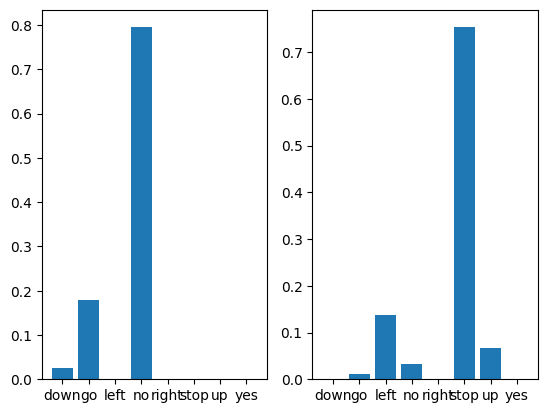

In [86]:
(start, layer, end) = get_reference_layer("resizing_24", model)
norm_weights = listify(get_layer_weights("normalization_24", model))
conv_weights1 = listify(get_layer_weights("conv2d_48", model))
conv_weights2 = listify(get_layer_weights("conv2d_49", model))
weights1 = listify(get_layer_weights("dense_51",model))
weights2 = listify(get_layer_weights("dense_52",model))


layer_result = listify(model(x))

start_point = start(x)
testi = listify(layer(start_point))
#print(start_point)
start_point = listify(start_point)

width = 32
height = 32
w0 = listify(norm_weights)
w1 = listify(conv_weights1[0])
b1 = listify(conv_weights1[1])
w2 = listify(conv_weights2[0])
b2 = listify(conv_weights2[1])
w3 = listify(weights1[0])
b3 = listify(weights1[1])
w4 = listify(weights2[0])
b4 = listify(weights2[1])

step0 = resize(start_point, width, height)
print()
for i in range(len(testi)):
  print(testi[i])
step1 = normalize(step0, w0)
step2 = convolution(step1, w1, b1)
step3 = convolution(step2, w2, b2)
step4 = maxpool(step3)
step5 = flatten(step4)
step6 = dense1(step5, w3, b3)
layer_oma_result = dense2(step6, w4, b4)
print("valmis tulos = ", layer_result)
print("oma tulos = ", layer_oma_result)

plt.figure(1)
plt.subplot(1,2,1)
plt.bar(x_labels, tf.nn.softmax(layer_result[:]))
plt.subplot(1,2,2)
plt.bar(x_labels, tf.nn.softmax(layer_oma_result[:]))
plt.show()
